In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy
import seaborn as sns
from scipy.special import gamma
from utils import JacobiGL, constructD
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

# a)
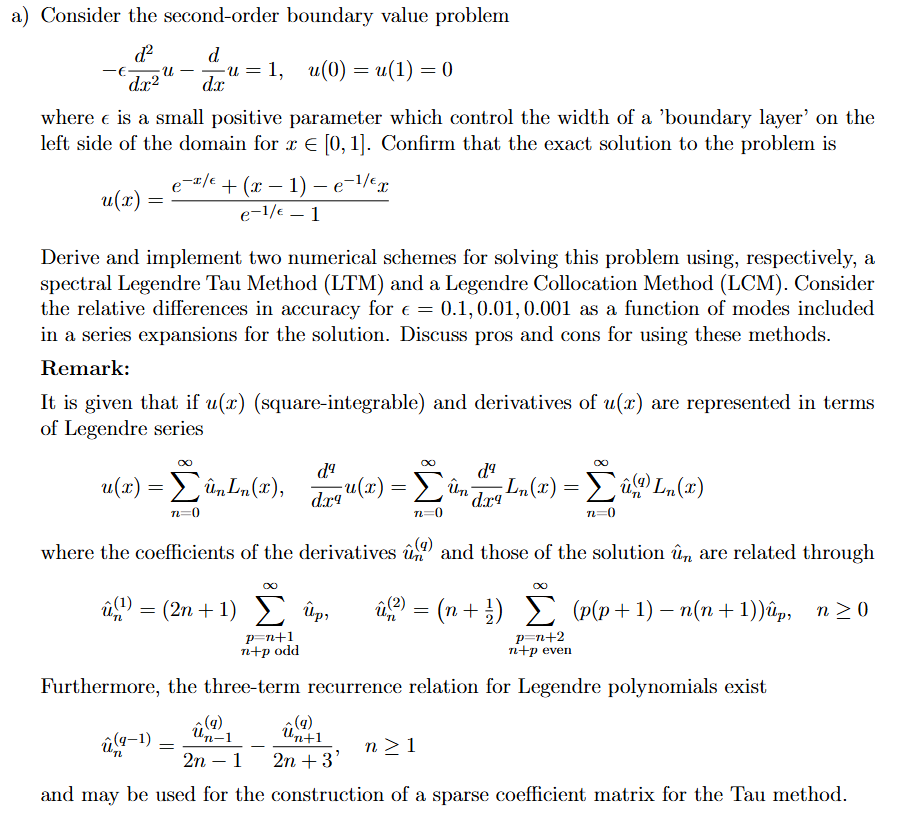

In [2]:
def u_func_1(x, epsilon):
    denom = np.exp(-1.0 / epsilon) - 1
    nom = +np.exp(-x / epsilon) + (x - 1) - np.exp(-1 / epsilon) * x
    return nom / denom


# Legendre
alpha = 0.0
beta = 0.0

# Let z be Jacobi domain, z ∈ [-1, 1]
a, b = 0.0, 1.0  # Domain


def jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Evaluates first `n+1` Jacobi polynomials at points `x` with parameters `alpha` and `beta`.
    Reflects L2, slide 12.

    Arguments:
        x: Points at which to evaluate the polynomials, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)

    Returns: Array of shape (m, n+1) where each column corresponds to a Jacobi polynomial
        Note that this is essentially the Vandermonde matrix for Jacobi polynomials.
    """
    assert n >= 0, "n must be non-negative"

    P = np.empty((len(x), n + 1))

    P[:, 0] = 1.0
    if n == 0:
        return P

    P[:, 1] = 1 / 2 * (alpha - beta + (alpha + beta + 2) * x)
    if n == 1:
        return P

    for k in range(1, n):
        a_nm1_n = (
            2
            * (k + alpha)
            * (k + beta)
            / ((2 * k + alpha + beta + 1) * (2 * k + alpha + beta))
        )
        a_n_n = (alpha**2 - beta**2) / (
            (2 * k + alpha + beta + 2) * (2 * k + alpha + beta)
        )
        a_np1_n = (
            2
            * (k + 1)
            * (k + alpha + beta + 1)
            / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta + 1))
        )

        P[:, k + 1] = ((a_n_n + x) * P[:, k] - a_nm1_n * P[:, k - 1]) / a_np1_n

    return P


def grad_jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Computes the gradient of the first `n+1` Jacobi polynomials at nodes `x`.
    Reflects L2, slide 15.

    Arguments:
        x: Points at which to evaluate the gradients, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)
    Returns: Array of shape (m, n+1) where each column corresponds to the gradient of a Jacobi polynomial
    """
    grad_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p_i = np.zeros_like(x)
        else:
            p_i = jacobi_p(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = 1 / 2 * (alpha + beta + i + 1)
        grad_p[:, i] = coeff * p_i

    return grad_p


# Legend

## a - Spectral Legendre Tau Method

array([-1.        , -0.93548387, -0.87096774, -0.80645161, -0.74193548,
       -0.67741935, -0.61290323, -0.5483871 , -0.48387097, -0.41935484,
       -0.35483871, -0.29032258, -0.22580645, -0.16129032, -0.09677419,
       -0.03225806,  0.03225806,  0.09677419,  0.16129032,  0.22580645,
        0.29032258,  0.35483871,  0.41935484,  0.48387097,  0.5483871 ,
        0.61290323,  0.67741935,  0.74193548,  0.80645161,  0.87096774,
        0.93548387,  1.        ])

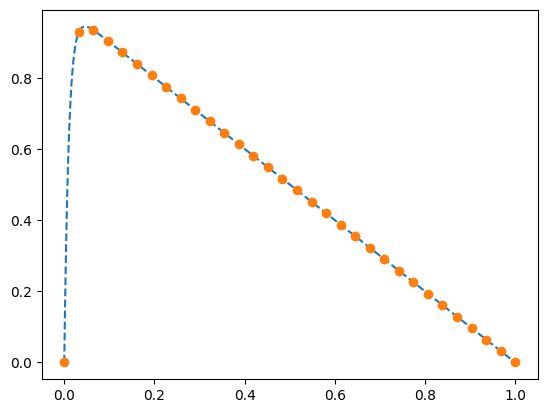

In [3]:
# We first solve Spectral Legendre Tau Method
N = 32
P = N - 1
epsilon = 0.01

# Build system matrix, L_N
a_coeff = -4.0 * epsilon
b_coeff = -2.0
c_coeff = 0.0

# Construct differentiation matrix
D = np.zeros((N, N))
for n in range(N):
    e_n = np.zeros(N)
    e_n[n] = 1.0

    # Use basis vectors as u_hat
    u_hat = e_n
    u_prime_hat = np.zeros_like(u_hat)

    # Correct Legendre differentiation rule:
    # u'_k = (2k+1) * sum_{p=k+1, p-k is odd}^N u_p
    for k in range(N):
        sum_val = 0.0
        for p in range(k + 1, N):
            if (p - k) % 2 == 1:
                sum_val += u_hat[p]
        u_prime_hat[k] = (2 * k + 1) * sum_val

    D[:, n] = u_prime_hat

L_N = a_coeff * D @ D + b_coeff * D + c_coeff * np.eye(N)
L_N.shape

# Construct A matrix where we sacrifice some rows for BCs
A = L_N.copy()
A[N - 2, :] = [1.0 for _ in range(N)]
A[N - 1, :] = [(-1) ** n for n in range(N)]

# Find nodal points
x_eval = np.linspace(0, 1, N, endpoint=True)
z_eval = 2 * x_eval - 1  # Map to [-1, 1]

# Now build RHS
V = jacobi_p(z_eval, alpha, beta, P)
display(z_eval)
f = np.zeros(N)

f = np.zeros(N)
f
f_hat = np.zeros(N)
f_hat[0] = 1.0
f_hat[N - 2] = 0.0
f_hat[N - 1] = 0.0
# D = constructD(z, alpha, beta)

# Now solve for coefficients
u_hat = np.linalg.solve(A, f_hat)


legendre_poly = np.polynomial.legendre.Legendre(u_hat)
u_hat = legendre_poly(z_eval)

# Now plot
x = np.linspace(0, 1, 500)
u_true = u_func_1(x, epsilon)

x_eval = np.linspace(0, 1, N, endpoint=True)

plt.plot(x, u_true, label="Exact solution", linestyle="dashed")
plt.plot(x_eval, u_hat, "o")


array([-1.        , -0.93548387, -0.87096774, -0.80645161, -0.74193548,
       -0.67741935, -0.61290323, -0.5483871 , -0.48387097, -0.41935484,
       -0.35483871, -0.29032258, -0.22580645, -0.16129032, -0.09677419,
       -0.03225806,  0.03225806,  0.09677419,  0.16129032,  0.22580645,
        0.29032258,  0.35483871,  0.41935484,  0.48387097,  0.5483871 ,
        0.61290323,  0.67741935,  0.74193548,  0.80645161,  0.87096774,
        0.93548387,  1.        ])

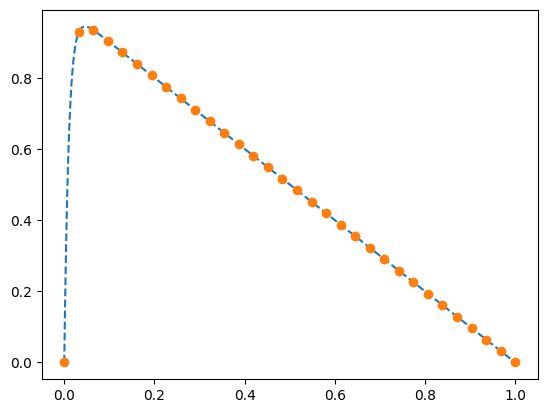

In [4]:
# We first solve Spectral Legendre Tau Method
N = 32
P = N - 1
epsilon = 0.01

# Build system matrix, L_N
a_coeff = -4.0 * epsilon
b_coeff = -2.0
c_coeff = 0.0

# Construct differentiation matrix
D = np.zeros((N, N))
for n in range(N):
    e_n = np.zeros(N)
    e_n[n] = 1.0

    # Use basis vectors as u_hat
    u_hat = e_n
    u_prime_hat = np.zeros_like(u_hat)

    # Correct Legendre differentiation rule:
    # u'_k = (2k+1) * sum_{p=k+1, p-k is odd}^N u_p
    for k in range(N):
        sum_val = 0.0
        for p in range(k + 1, N):
            if (p - k) % 2 == 1:
                sum_val += u_hat[p]
        u_prime_hat[k] = (2 * k + 1) * sum_val

    D[:, n] = u_prime_hat

L_N = a_coeff * D @ D + b_coeff * D + c_coeff * np.eye(N)
L_N.shape

# Construct A matrix where we sacrifice some rows for BCs
A = L_N.copy()
A[N - 2, :] = [1.0 for _ in range(N)]
A[N - 1, :] = [(-1) ** n for n in range(N)]

# Find nodal points
x_eval = np.linspace(0, 1, N, endpoint=True)
z_eval = 2 * x_eval - 1  # Map to [-1, 1]

# Now build RHS
V = jacobi_p(z_eval, alpha, beta, P)
display(z_eval)
f = np.ones(N)
f_hat = np.linalg.solve(V, f)

# Impose BCs, we override highest order modes for least error assuming
# monotonically decreasing modal coefficients
f_hat[-2] = 0.0
f_hat[-1] = 0.0

# Now solve for coefficients
u_hat = np.linalg.solve(A, f_hat)

legendre_poly = np.polynomial.legendre.Legendre(u_hat)
u_hat = legendre_poly(z_eval)

# Now plot
x = np.linspace(0, 1, 500)
u_true = u_func_1(x, epsilon)

x_eval = np.linspace(0, 1, N, endpoint=True)

plt.plot(x, u_true, label="Exact solution", linestyle="dashed")
plt.plot(x_eval, u_hat, "o")


## a - Legendre Collocation Method

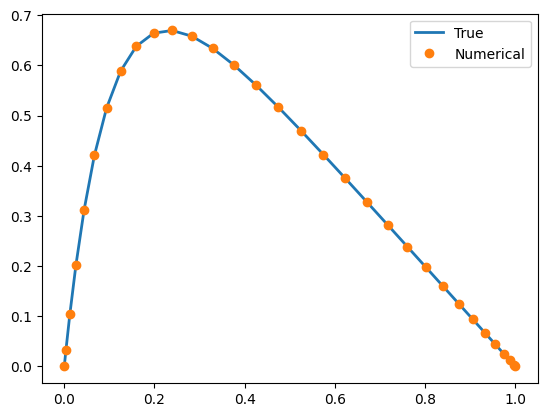

In [5]:
N = 32
P = N - 1

# Model parameters
epsilon = 0.1

z_gl = JacobiGL(alpha, beta, P)  # Includes boundaries, domain: [-1, 1]
x_gl = 0.5 * (b - a) * (z_gl + 1) + a  # Map to [a, b]
u_gl_true = u_func_1(x_gl, epsilon)

D_z = constructD(z_gl, alpha, beta)
# D_x = transform_dz_to_dx(z_gl, a, b) * D_z  # Chain rule

A = -4.0 * epsilon * np.eye(N)
B = -2.0 * np.eye(N)
C = np.zeros((N, N))

# Set up approximate operator
L_N = D_z @ A @ D_z + B @ D_z + C

# RHS
F = np.ones(N)

# Enforce BCs
L_N[0, :] = 0.0
L_N[0, 0] = 1.0
L_N[-1, :] = 0.0
L_N[-1, -1] = 1.0
F[0] = 0.0
F[-1] = 0.0

# Solve
u_gl = np.linalg.solve(L_N, F)

plt.plot(x_gl, u_gl_true, lw=2, label="True")
plt.plot(x_gl, u_gl, "o", label="Numerical")
plt.legend()


# b)
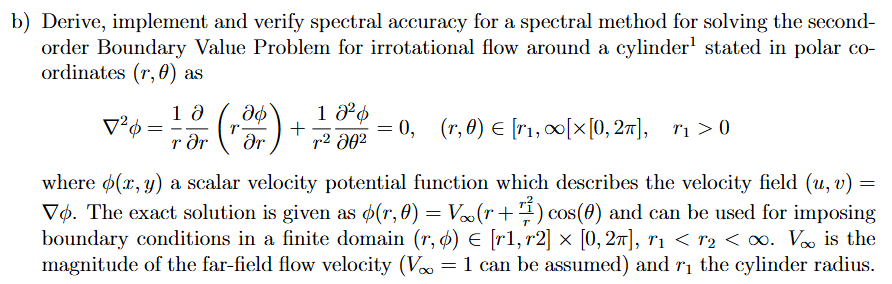

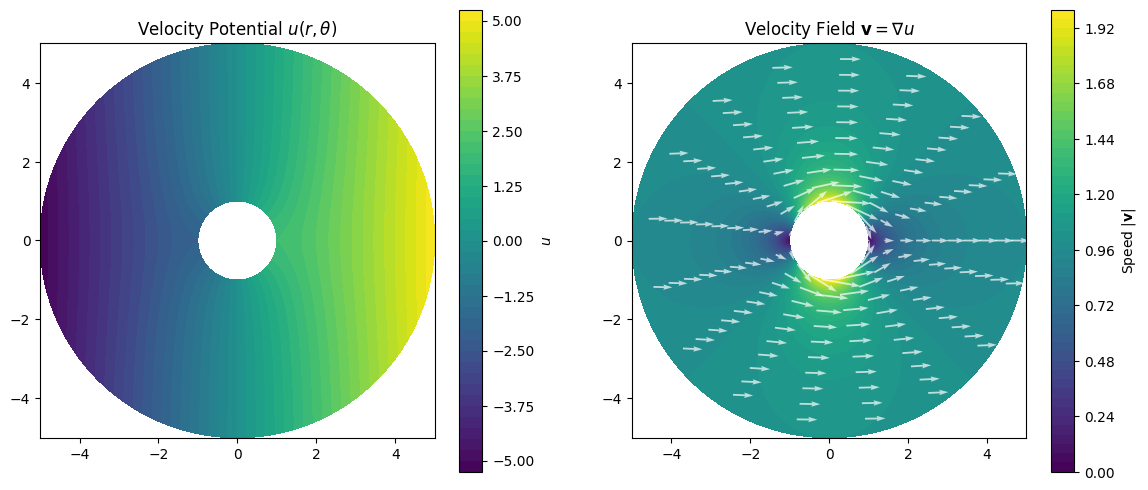

In [6]:
# Canonical Laplacian operator, so in cartesians it is simply pdv(ϕ, x, 2) + pdv(ϕ, y, 2) = 0
# Known parameters
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 5.0  # I came up with this one


def u_func_2_rtheta(r, theta):
    return V_inf * (r + r_1**2 / r) * np.cos(theta)


def u_func_2_xy(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return u_func_2_rtheta(r, theta)


def transform2xy(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def transform2rtheta(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta


# Start by plotting the true solution
r_true = np.linspace(r_1, r_2, 500)
theta_true = np.linspace(0, 2 * np.pi, 500)
R_true, Theta_true = np.meshgrid(r_true, theta_true)
U_true = u_func_2_rtheta(R_true, Theta_true)

# Get velocities
V_r = np.gradient(U_true, r_true, axis=1)  # derivative along r direction
V_theta = (
    np.gradient(U_true, theta_true, axis=0) / R_true
)  # derivative along theta direction

# Convert to Cartesian grid for plotting
X_true = R_true * np.cos(Theta_true)
Y_true = R_true * np.sin(Theta_true)

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta_true) - V_theta * np.sin(Theta_true)
V_y = V_r * np.sin(Theta_true) + V_theta * np.cos(Theta_true)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
contour1 = ax1.contourf(X_true, Y_true, U_true, levels=50, cmap="viridis")
ax1.set_aspect("equal")
ax1.set_title("Velocity Potential $u(r,\\theta)$")
plt.colorbar(contour1, ax=ax1, label="$u$")

# Velocity magnitude with streamlines
speed = np.sqrt(V_x**2 + V_y**2)
contour2 = ax2.contourf(X_true, Y_true, speed, levels=50, cmap="viridis")
skip_x = 30
skip_y = 50
ax2.quiver(
    X_true[::skip_x, ::skip_y],
    Y_true[::skip_x, ::skip_y],
    V_x[::skip_x, ::skip_y],
    V_y[::skip_x, ::skip_y],
    color="white",
    alpha=0.7,
    scale=20,
)
ax2.set_aspect("equal")
ax2.set_title("Velocity Field $\\mathbf{v} = \\nabla u$")
plt.colorbar(contour2, ax=ax2, label="Speed $|\\mathbf{v}|$")

(32, 64)

Text(-0.1, 0.5, 'Exact Solution')

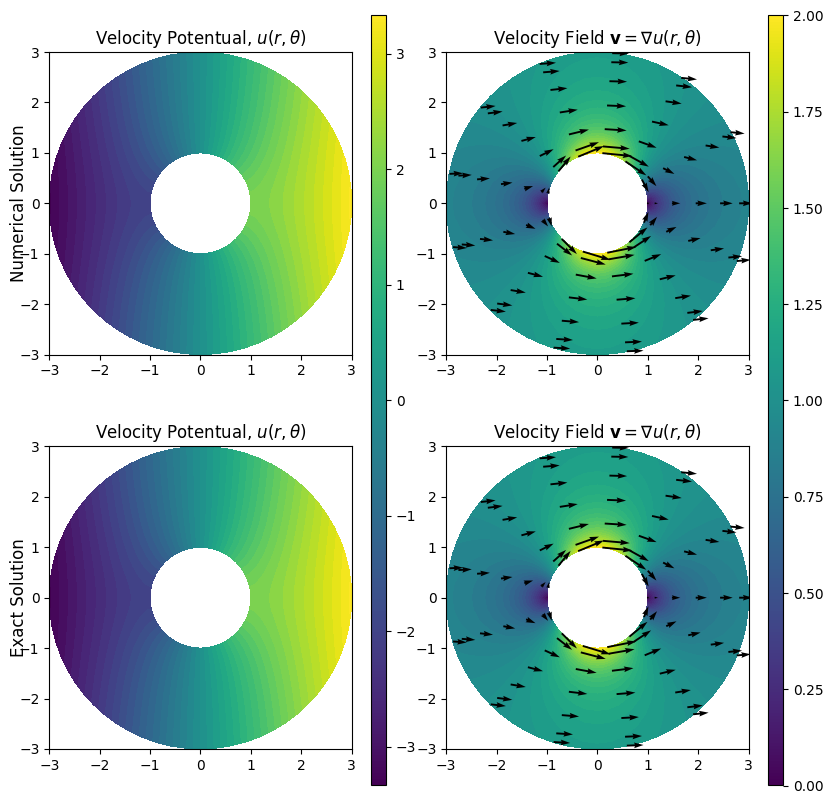

In [ ]:
# We must need to do a really strange mapping since z=-1 -> r_1, z=1 -> r_2

# Discretisation parameters
N_r = 32  # Nodes in r direction
N_theta = 64  # Nodes in theta direction
P_r = N_r - 1  # Polynomial degree in r direction
P_theta = N_theta - 1  # Polynomial degree in theta direction

# Constants for the problem
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 3.0  # I came up with this one

# Jacobi parameters for r direction
alpha_r = 0.0
beta_r = 0.0

# Get nodes for both dimensions
z_r = JacobiGL(alpha_r, beta_r, P_r)  # GL for Legendre
z_theta = np.linspace(0.0, 2 * np.pi, N_theta, endpoint=False)  # Equidistant in theta

# Get differentiation matrix in r direction
D_z = constructD(z_r, alpha_r, beta_r)

# Get differentiation matrix in theta direction
D_theta = np.zeros((N_theta, N_theta))

for i in range(N_theta):
    for j in range(N_theta):
        if i != j:
            # Off-diagonal elements
            D_theta[i, j] = 0.5 * (-1) ** (i - j) / np.tan(np.pi * (i - j) / N_theta)
        # Diagonal elements are zero for periodic functions

# Set up transformation from z_r to r
r_r = (r_2 - r_1) / 2 * z_r + (r_1 + r_2) / 2  # Map to [r_1, r_2]
J_zr = 2 / (r_2 - r_1)  # Jacobian of the transformation

R, Theta = np.meshgrid(r_r, z_theta, indexing="ij")
R_flat = R.flatten()
Theta_flat = Theta.flatten()

# Set up matrices for Laplacian
I_r = np.eye(N_r)
I_theta = np.eye(N_theta)
R_inv_diag = np.diag(1.0 / R_flat)
R_inv_sq_diag = np.diag(1.0 / R_flat**2)

# Create D using Kronecker products
D_z_full = np.kron(D_z, np.eye(N_theta))
D_theta_full = np.kron(np.eye(N_r), D_theta)

L_N = (
    (J_zr ** 2) * (D_z_full @ D_z_full)
    + R_inv_diag @ (J_zr * D_z_full)
    + R_inv_sq_diag @ (D_theta_full @ D_theta_full)
)

# Inner boundary
for j in range(N_theta):
    idx = 0 * N_theta + j  # First radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Outer boundary (i=N_r-1, all theta)
for j in range(N_theta):
    idx = (N_r - 1) * N_theta + j  # Last radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# 12) Set up RHS
N_total = N_r * N_theta
F = np.zeros(N_total)

# Set boundary values
for j in range(N_theta):
    # Inner
    F[0 * N_theta + j] = u_func_2_rtheta(r_1, z_theta[j])

    # Outer
    F[(N_r - 1) * N_theta + j] = u_func_2_rtheta(r_2, z_theta[j])

# 13) Solve
u_flat = np.linalg.solve(L_N, F)

# 14) Reshape back to 2D
u_numerical = u_flat.reshape((N_r, N_theta), order="C")
display(u_numerical.shape)

### Prepare for plot
u_exact = u_func_2_rtheta(R, Theta)

# This is for plotting to close the circle in theta
z_theta_plot = np.append(z_theta, 2*np.pi)
u_numerical_plot = np.hstack([u_numerical, u_numerical[:, 0:1]])

R_plot, Theta_plot = np.meshgrid(r_r, z_theta_plot, indexing="ij")
u_exact_plot = u_func_2_rtheta(R_plot, Theta_plot)
X_plot = R_plot * np.cos(Theta_plot)
Y_plot = R_plot * np.sin(Theta_plot)


# Numerical - Potential
# Numerical - Field
V_r = J_zr * (D_z @ u_numerical)
V_theta = (1.0 / R) * (u_numerical @ D_theta.T)

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta) - V_theta * np.sin(Theta)
V_y = V_r * np.sin(Theta) + V_theta * np.cos(Theta)

speed = np.sqrt(V_x**2 + V_y**2)

# Exact - Potential
# Exact - Field
V_r_exact = J_zr * (D_z @ u_exact)
V_theta_exact = (1.0 / R) * (u_exact @ D_theta.T)

# Convert to Cartesian velocities
V_x_exact = V_r_exact * np.cos(Theta) - V_theta_exact * np.sin(Theta)
V_y_exact = V_r_exact * np.sin(Theta) + V_theta_exact * np.cos(Theta)

speed_exact = np.sqrt(V_x_exact**2 + V_y_exact**2)

# 15) Plot
# Row 1: Numerical Solution
# Row 2: Exact Solution
# Column 1: Velocity Potential
# Column 2: Velocity Field

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
cmap_potential = plt.get_cmap('viridis')
cmap_field = plt.get_cmap('viridis')
_potentials = [u_numerical, u_exact]
normalizer_potential = mpl.colors.Normalize(vmin=np.min(_potentials), vmax=np.max(_potentials))
_fields = [speed, speed_exact]
normalizer_field = mpl.colors.Normalize(vmin=np.min(_fields), vmax=np.max(_fields))

# Numerical - Potential
contour1 = axs[0, 0].contourf(X_plot, Y_plot, u_numerical_plot, levels=50, cmap=cmap_potential, norm=normalizer_potential)
axs[0, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[0, 0].set_aspect("equal")

# Numerical - Field
# For plotting, append first column to the end to close the circle
speed_plot = np.hstack([speed, speed[:, 0:1]])
V_x_plot = np.hstack([V_x, V_x[:, 0:1]])
V_y_plot = np.hstack([V_y, V_y[:, 0:1]])
contour2 = axs[0, 1].contourf(X_plot, Y_plot, speed_plot, levels=50, cmap=cmap_field, norm=normalizer_field)
skip_x = 5
skip_y = 5
axs[0, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot[::skip_x, ::skip_y],
    V_y_plot[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[0, 1].set_aspect("equal")
axs[0, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r, \\theta)$")

# Exact - Potential
contour1 = axs[1, 0].contourf(X_plot, Y_plot, u_exact_plot, levels=50, cmap=cmap_potential, norm=normalizer_potential)
axs[1, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[1, 0].set_aspect("equal")

# Exact - Field
# For plotting, append first column to the end to close the circle
speed_plot_exact = np.hstack([speed_exact, speed_exact[:, 0:1]])
V_x_plot_exact = np.hstack([V_x_exact, V_x_exact[:, 0:1]])
V_y_plot_exact = np.hstack([V_y_exact, V_y_exact[:, 0:1]])
contour2 = axs[1, 1].contourf(X_plot, Y_plot, speed_plot_exact, levels=50, cmap=cmap_field, norm=normalizer_field)
axs[1, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot_exact[::skip_x, ::skip_y],
    V_y_plot_exact[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[1, 1].set_aspect("equal")
axs[1, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r,\\theta)$")

fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Colorbars
im_potential = mpl.cm.ScalarMappable(norm=normalizer_potential)
cbar_potential = fig.colorbar(im_potential, ax=[axs[0,0], axs[1,0]], aspect=50)
im_field = mpl.cm.ScalarMappable(norm=normalizer_field)
cbar_field = fig.colorbar(im_field, ax=[axs[0,1], axs[1,1]], aspect=50)
# Vertical titles
axs[0, 0].text(
    -0.1,
    0.5,
    "Numerical Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[0, 0].transAxes,
    size=12,
)
axs[1, 0].text(
    -0.1,
    0.5,
    "Exact Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[1, 0].transAxes,
    size=12,
)

# plt.colorbar(contour1, ax=axs[0, 0])

# axs[0, 1].set_title('Velocity Field, $\\mathbf{v} = \\nabla u(r,\\theta)$')


# contour2 = ax2.contourf(X, Y, u_numerical, levels=50, cmap='viridis')
# ax2.set_title('Numerical Solution')
# ax2.set_aspect('equal')
# plt.colorbar(contour2, ax=ax2)

# fig.tight_layout()

Text(-0.1, 0.5, 'Exact Solution')

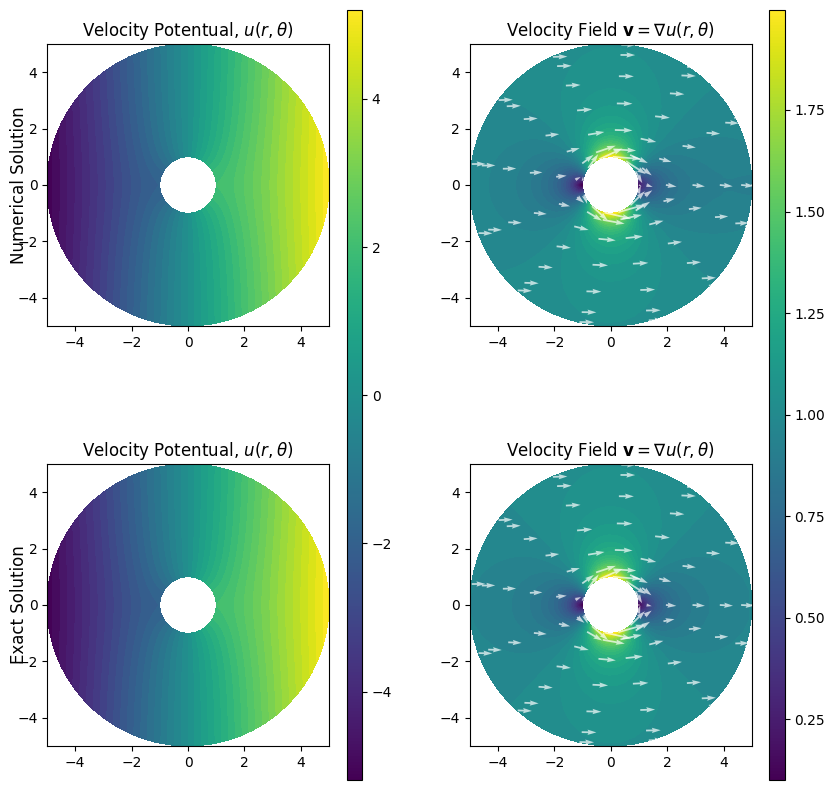

In [ ]:
# We must need to do a really strange mapping since z=-1 -> r_1, z=1 -> r_2
N_r = 32  # Nodes in r direction
N_theta = 64  # Nodes in theta direction
P_r = N_r - 1  # Polynomial degree in r direction
P_theta = N_theta - 1  # Polynomial degree in theta direction

#
V_inf = 1.0
r_1 = 1.0
r_2 = 5.0

# Jacobi parameters for r direction (Legendre)
alpha_r = 0.0
beta_r = 0.0

# Get nodes for both dimensions
z_r = JacobiGL(alpha_r, beta_r, P_r)  # GL for Legendre in z domain [-1, 1]
z_theta = np.linspace(0.0, 2 * np.pi, N_theta, endpoint=True)

# Get differentiation matrix in z direction
D_z = constructD(z_r, alpha_r, beta_r)

# Get differentiation matrix in theta direction
D_theta = np.zeros((N_theta, N_theta))
h = 2 * np.pi / N_theta
for i in range(N_theta):
    for j in range(N_theta):
        if i != j:
            # Off-diagonal elements for equidistant grid
            D_theta[i, j] = 0.5 * (-1)**(i - j) * np.cos( (i-j)*h/2 ) / np.sin( (i-j)*h/2 )

# ---- CORRECTIONS START HERE ----

# 1. Define the mapping and its Jacobian
# Map z in [-1, 1] to r in [r_1, r_2]
r_mapped = (r_2 - r_1) / 2 * z_r + (r_1 + r_2) / 2
J = 2.0 / (r_2 - r_1)  # Jacobian dz/dr

# Create meshgrid for physical coordinates
R, Theta = np.meshgrid(r_mapped, z_theta, indexing="ij")
R_flat = R.flatten()
Theta_flat = Theta.flatten()

# 2. Create full operators using Kronecker products
I_r = np.eye(N_r)
I_theta = np.eye(N_theta)

# Note: D_z is the derivative w.r.t z, not r. Let's name it clearly.
D_z_full = np.kron(D_z, I_theta)
D_theta_full = np.kron(I_r, D_theta)

# Second derivative operators
D_zz_full = D_z_full @ D_z_full
D_thetatheta_full = D_theta_full @ D_theta_full

# 3. Create diagonal matrices for variable coefficients
R_inv_diag = np.diag(1.0 / R_flat)
R_inv_sq_diag = np.diag(1.0 / R_flat**2)

# 4. Assemble the final operator L_N based on the transformed PDE
# L_N represents: J^2 * d^2/dz^2 + (1/r) * J * d/dz + (1/r^2) * d^2/d(theta)^2
L_N = (
    (J**2) * D_zz_full
    + R_inv_diag @ (J * D_z_full)
    + R_inv_sq_diag @ D_thetatheta_full
)

# ---- CORRECTIONS END HERE ----


# The rest of your code for imposing BCs is correct as written.
# Inner boundary (i=0, all theta)
for j in range(N_theta):
    idx = 0 * N_theta + j
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Outer boundary (i=N_r-1, all theta)
for j in range(N_theta):
    idx = (N_r - 1) * N_theta + j
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Set up RHS
N_total = N_r * N_theta
F = np.zeros(N_total)

# Set boundary values
for j in range(N_theta):
    # Inner: phi(r_1, theta) = V_inf * (r_1 + r_1^2/r_1) * cos(theta)
    F[0 * N_theta + j] = V_inf * (r_1 + r_1**2 / r_1) * np.cos(z_theta[j])

    # Outer: phi(r_2, theta) = V_inf * (r_2 + r_1^2/r_2) * cos(theta)
    F[(N_r - 1) * N_theta + j] = V_inf * (r_2 + r_1**2 / r_2) * np.cos(z_theta[j])

# Solve the system
u_flat = np.linalg.solve(L_N, F)

# Reshape back to 2D
u_numerical = u_flat.reshape((N_r, N_theta))

# (The rest of your plotting code will now work correctly with the accurate numerical solution)

### Prepare for plot
u_exact = u_func_2_rtheta(R, Theta)
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Numerical - Potential
# Numerical - Field
V_r = np.gradient(u_numerical, r_r, axis=0)  # derivative along r direction
V_theta = (
    np.gradient(u_numerical, z_theta, axis=1) / R
)  # derivative along theta direction

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta) - V_theta * np.sin(Theta)
V_y = V_r * np.sin(Theta) + V_theta * np.cos(Theta)

speed = np.sqrt(V_x**2 + V_y**2)

# Exact - Potential
# Exact - Field
V_r_exact = np.gradient(u_exact, r_r, axis=0)  # derivative along r direction
V_theta_exact = (
    np.gradient(u_exact, z_theta, axis=1) / R
)  # derivative along theta direction

# Convert to Cartesian velocities
V_x_exact = V_r_exact * np.cos(Theta) - V_theta_exact * np.sin(Theta)
V_y_exact = V_r_exact * np.sin(Theta) + V_theta_exact * np.cos(Theta)

speed_exact = np.sqrt(V_x_exact**2 + V_y_exact**2)

# 15) Plot
# Row 1: Numerical Solution
# Row 2: Exact Solution
# Column 1: Velocity Potential
# Column 2: Velocity Field

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
cmap_potential = plt.get_cmap('viridis')
cmap_field = plt.get_cmap('viridis')
_potentials = [u_numerical, u_exact]
normalizer_potential = mpl.colors.Normalize(vmin=np.min(_potentials), vmax=np.max(_potentials))
_fields = [speed, speed_exact]
normalizer_field = mpl.colors.Normalize(vmin=np.min(_fields), vmax=np.max(_fields))

# Numerical - Potential
contour1 = axs[0, 0].contourf(X, Y, u_exact, levels=50, cmap=cmap_potential, norm=normalizer_potential)
axs[0, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[0, 0].set_aspect("equal")

# Numerical - Field
contour2 = axs[0, 1].contourf(X, Y, speed, levels=50, cmap=cmap_field, norm=normalizer_field)
skip_x = 5
skip_y = 5
axs[0, 1].quiver(
    X[::skip_x, ::skip_y],
    Y[::skip_x, ::skip_y],
    V_x[::skip_x, ::skip_y],
    V_y[::skip_x, ::skip_y],
    color="white",
    alpha=0.7,
    scale=20,
)
axs[0, 1].set_aspect("equal")
axs[0, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r, \\theta)$")

# Exact - Potential
contour1 = axs[1, 0].contourf(X, Y, u_exact, levels=50, cmap=cmap_potential, norm=normalizer_potential)
axs[1, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[1, 0].set_aspect("equal")

# Exact - Field
contour2 = axs[1, 1].contourf(X, Y, speed_exact, levels=50, cmap=cmap_field, norm=normalizer_field)
axs[1, 1].quiver(
    X[::skip_x, ::skip_y],
    Y[::skip_x, ::skip_y],
    V_x_exact[::skip_x, ::skip_y],
    V_y_exact[::skip_x, ::skip_y],
    color="white",
    alpha=0.7,
    scale=20,
)
axs[1, 1].set_aspect("equal")
axs[1, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r,\\theta)$")

# Colorbars
im_potential = mpl.cm.ScalarMappable(norm=normalizer_potential)
cbar_potential = fig.colorbar(im_potential, ax=[axs[0,0], axs[1,0]], aspect=50)
im_field = mpl.cm.ScalarMappable(norm=normalizer_field)
cbar_field = fig.colorbar(im_field, ax=[axs[0,1], axs[1,1]], aspect=50)
# Vertical titles
axs[0, 0].text(
    -0.1,
    0.5,
    "Numerical Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[0, 0].transAxes,
    size=12,
)
axs[1, 0].text(
    -0.1,
    0.5,
    "Exact Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[1, 0].transAxes,
    size=12,
)


L_N shape: (64, 64)


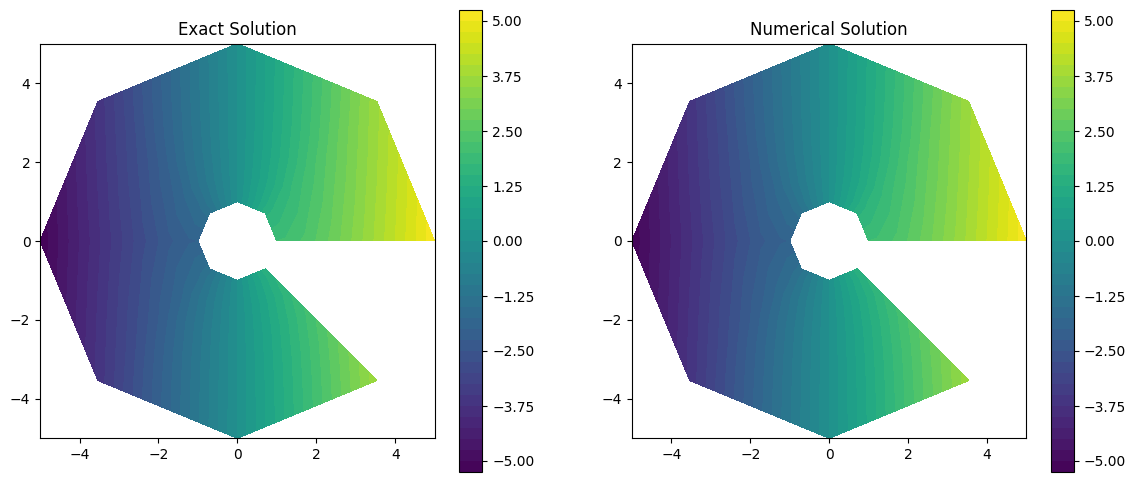

In [ ]:
# Parameters
N_r = 8
N_theta = 8
P_r = N_r - 1

# Physical domain
r_1 = 1.0
r_2 = 5.0

# 1) Get nodes in canonical domain
z_r = JacobiGL(alpha_r, beta_r, P_r)  # [-1, 1]
theta_nodes = np.linspace(0, 2 * np.pi, N_theta, endpoint=False)  # [0, 2π)

# 2) Map radial nodes to physical domain [r_1, r_2]
r_nodes = 0.5 * (r_2 - r_1) * (z_r + 1) + r_1

# 3) Get differentiation matrices in canonical/physical space
D_z_r = constructD(z_r, alpha_r, beta_r)  # d/dz in canonical domain
D_theta = np.zeros((N_theta, N_theta))
for i in range(N_theta):
    for j in range(N_theta):
        if i != j:
            D_theta[i, j] = 0.5 * (-1) ** (i - j) / np.tan(np.pi * (i - j) / N_theta)

# 4) Transform to physical radial derivative using chain rule
# dr/dz = (r_2 - r_1) / 2, so d/dr = (2/(r_2-r_1)) * d/dz
D_r = (2.0 / (r_2 - r_1)) * D_z_r

# 5) Create 2D mesh
R, Theta = np.meshgrid(r_nodes, theta_nodes, indexing="ij")

# 6) Flatten the 2D grid to 1D vector
# Convention: u[i*N_theta + j] corresponds to u(r_i, theta_j)
N_total = N_r * N_theta

# 7) Build 2D differentiation operators using Kronecker products
I_r = np.eye(N_r)
I_theta = np.eye(N_theta)

# d/dr operator (acts on r, identity on theta)
D_r_2d = np.kron(D_r, I_theta)

# d/dtheta operator (identity on r, acts on theta)
D_theta_2d = np.kron(I_r, D_theta)

# 8) Build second derivatives
D2_r_2d = D_r_2d @ D_r_2d
D2_theta_2d = D_theta_2d @ D_theta_2d

# 9) Build 1/r and 1/r^2 as diagonal matrices
# Flatten R in same order as solution vector
R_flat = R.flatten(order="C")  # or 'F' depending on your convention
inv_R = scipy.sparse.diags(1.0 / R_flat)
inv_R2 = scipy.sparse.diags(1.0 / R_flat**2)

# 10) Construct Laplacian: ∇²u = ∂²u/∂r² + (1/r)∂u/∂r + (1/r²)∂²u/∂θ²
L_N = D2_r_2d + inv_R @ D_r_2d + inv_R2 @ D2_theta_2d

print(f"L_N shape: {L_N.shape}")  # Should be (N_r * N_theta, N_r * N_theta)

# 11) For Laplace equation: L_N @ u_flat = 0
# But you need to apply boundary conditions:

# Boundary conditions:
# - At r = r_1 (inner cylinder): u = something
# - At r = r_2 (outer boundary): u = something
# - Periodic in theta (automatically satisfied by Fourier)

# Example: Set BCs for inner and outer radial boundaries
# Inner boundary (i=0, all theta)
for j in range(N_theta):
    idx = 0 * N_theta + j  # First radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Outer boundary (i=N_r-1, all theta)
for j in range(N_theta):
    idx = (N_r - 1) * N_theta + j  # Last radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# 12) Set up RHS
F = np.zeros(N_total)

# Set boundary values
for j in range(N_theta):
    # Inner: u(r_1, theta) = V_inf * (r_1 + r_1^2/r_1) * cos(theta)
    F[0 * N_theta + j] = V_inf * (r_1 + r_1**2 / r_1) * np.cos(theta_nodes[j])

    # Outer: u(r_2, theta) = V_inf * (r_2 + r_1^2/r_2) * cos(theta)
    F[(N_r - 1) * N_theta + j] = V_inf * (r_2 + r_1**2 / r_2) * np.cos(theta_nodes[j])

# 13) Solve
u_flat = np.linalg.solve(L_N, F)

# 14) Reshape back to 2D
u_numerical = u_flat.reshape((N_r, N_theta), order="C")

# 15) Plot
u_exact = u_func_2_rtheta(R, Theta)
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
contour1 = ax1.contourf(X, Y, u_exact, levels=50, cmap="viridis")
ax1.set_title("Exact Solution")
ax1.set_aspect("equal")
plt.colorbar(contour1, ax=ax1)

contour2 = ax2.contourf(X, Y, u_numerical, levels=50, cmap="viridis")
ax2.set_title("Numerical Solution")
ax2.set_aspect("equal")
plt.colorbar(contour2, ax=ax2)